In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import statistics

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,roc_auc_score,f1_score,recall_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

import graphviz
import collections

from tqdm import tqdm
import itertools

# Data

In [4]:
indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', sheet_name='price', index_col=1, usecols=[0,2,3])

In [782]:
indices_price = indices_price_excel.pivot(columns='ISIN', values='Quote')[['SPI Index', 'SMIMC Index', 'SMCI Index', 'SPIEX Index', 'SPI20 Index']]
indices_price.dropna(inplace=True)
indices_price.head(3)

ISIN,SPI Index,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
Date,,,,,
1996-01-03,2172.31,423.57,2040.95,421.60,3384.5
1996-01-04,2182.67,426.47,2049.35,423.28,3395.8
1996-01-05,2175.09,426.04,2054.88,424.38,3376.1


In [60]:
def price_to_perf(df):
    return (1 + df.pct_change()).cumprod()

In [50]:
benchmark_perf = price_to_perf(indices_price['SPI Index'])

In [7]:
daily_returns = indices_price.pct_change()
daily_returns_cum = (1 + daily_returns).cumprod()

In [8]:
ema_10 = daily_returns_cum.ewm(span=10).mean()
ema_60 = daily_returns_cum.ewm(span=60).mean()
ema_130 = daily_returns_cum.ewm(span=130).mean()

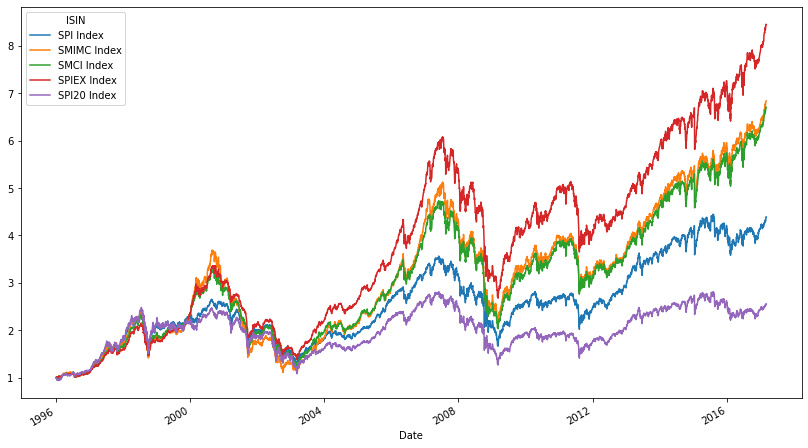

In [9]:
(1+indices_price.pct_change()).cumprod().plot(figsize=(14,8))
plt.show()

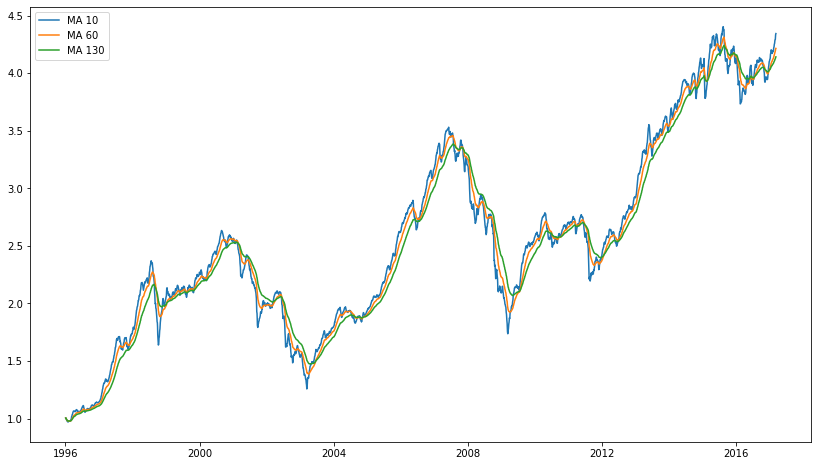

In [10]:
fig = plt.figure(figsize=(14,8))
plt.plot(ema_10['SPI Index'], label='MA 10')
plt.plot(ema_60['SPI Index'], label='MA 60')
plt.plot(ema_130['SPI Index'], label='MA 130')
plt.legend()
plt.show()

In [11]:
best_bet = indices_price.pct_change(periods=30).rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 0., 5: 1.}).shift(-30).iloc[180:].dropna()
best_bet = best_bet.asfreq(freq='M', method='ffill')

In [116]:
best_bet

ISIN,SPI Index,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
Date,,,,,
1996-09-30,0.0,0.0,0.0,0.0,1.0
1996-10-31,0.0,1.0,0.0,0.0,0.0
1996-11-30,0.0,1.0,0.0,0.0,0.0
1996-12-31,0.0,1.0,0.0,0.0,0.0
1997-01-31,0.0,0.0,0.0,0.0,1.0
1997-02-28,0.0,0.0,1.0,0.0,0.0
1997-03-31,0.0,0.0,0.0,0.0,1.0
1997-04-30,0.0,1.0,0.0,0.0,0.0
1997-05-31,0.0,0.0,0.0,0.0,1.0


In [145]:
x = []
for i in best_bet.index:
    df_ret = indices_price.loc[:i]
    df_ret = df_ret.iloc[-180:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    df_ema_10 = df_ret_cum.ewm(span=10).mean()
    df_ema_60 = df_ret_cum.ewm(span=60).mean()
    df_ema_130 = df_ret_cum.ewm(span=130).mean()
    x_temp = pd.concat([df_ema_10, df_ema_60, df_ema_130], axis=1).dropna()
    x.append(x_temp.values)

In [146]:
X = np.array(x)
y = np.array(best_bet)

In [147]:
nsamples, nx, ny = X.shape
X = X.reshape((nsamples, nx * ny))

In [148]:
np.shape(X)

(244, 2700)

In [149]:
np.shape(y)

(244, 5)

In [150]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.5, shuffle=True, stratify=y)

In [151]:
split_index = len(y) // 2
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[:split_index:]

In [72]:
split_date = str(best_bet.iloc[split_index].name)
split_date

'2006-11-30 00:00:00'

# Models

In [152]:
def pred_to_perf(df_pred):
    first_date = df_pred.index[0]
    return (1 + (df_pred.reindex(daily_returns[first_date:].index, method='ffill').shift(1) * daily_returns[first_date:]).sum(axis=1)).cumprod()

In [153]:
n_split = 5

### KNN

In [154]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_model', KNeighborsClassifier()))
pipeline = Pipeline(estimators)

In [155]:
# number of neighbors K
knn_grid = {'knn_model__n_neighbors' : list(range(2, 30, 2)),
            'knn_model__weights'     : ['uniform', 'distance'],
            'knn_model__algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Cross validation search with all combination of parameters possible 
knn_cv = GridSearchCV(pipeline, knn_grid, n_jobs = -1, verbose = 1)
knn_cv.fit(X_train,y_train)

print(knn_cv.best_params_)
best_param_knn = list(knn_cv.best_params_.values())

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s


{'knn_model__algorithm': 'auto', 'knn_model__n_neighbors': 2, 'knn_model__weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 545 out of 560 | elapsed:    4.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    4.7s finished


In [156]:
best_algo, best_K, best_weights = best_param_knn

pipeline.set_params(knn_model__n_neighbors = best_K, knn_model__weights = best_weights)
pipeline.fit(X_train, y_train)

y_hat_knn_train = pipeline.predict(X_train)
y_hat_knn_test = pipeline.predict(X_test)
df_pred_knn = pd.DataFrame(data=y_hat_knn_test, columns=indices_price.columns, index=best_bet[split_index:].index)

In [157]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_knn_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_knn_test, y_test), 2), '%')

Accuracy on train set 100.0 %
Accuracy on test set 27.87 %


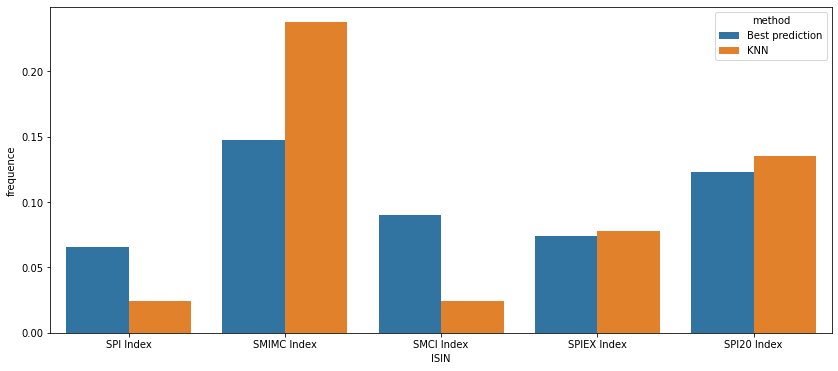

In [158]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_bet[split_index:].sum(axis=0) / len(y), df_pred_knn.sum(axis=0) / len(y)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

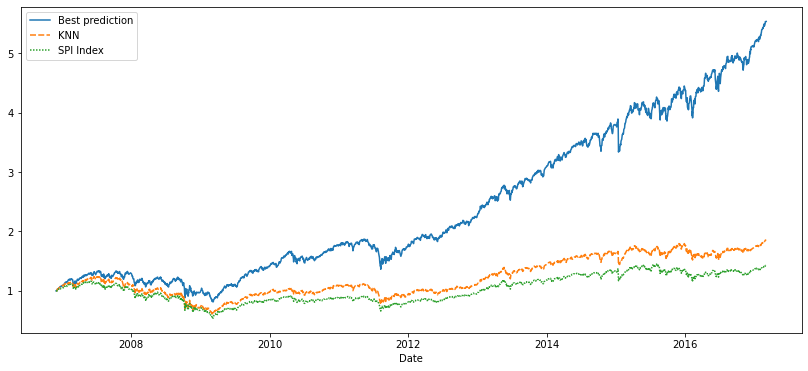

In [159]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_bet[split_index:]), pred_to_perf(df_pred_knn)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

### Decision Tree

In [160]:
# Maximum number of levels in tree
dt_max_depth = list(range(10,20))
dt_max_depth.append(None)

# Minimum number of samples required to be at a leaf node
dt_min_samples_leaf = list(range(2,5))

# Minimum number of samples required to split a node
dt_min_samples_split = list(range(2,5))

dt_criterion = ['entropy', 'gini']

dt_grid = {'max_depth'        : dt_max_depth,
           'min_samples_leaf' : dt_min_samples_leaf,
           'min_samples_split': dt_min_samples_split,
           'criterion'        : dt_criterion }

print('length of the grid', len(dt_max_depth) * len(dt_min_samples_leaf) * len(dt_min_samples_split) * len(dt_criterion))

length of the grid 198


In [161]:
dt_default = DecisionTreeClassifier()

# Create the random search for a Random Forest model
dt_cv = GridSearchCV(estimator = dt_default, param_grid = dt_grid, 
                            cv = n_split, verbose = 2, n_jobs = -1)
dt_cv.fit(X_train,y_train)

print(dt_cv.best_params_)
best_param_dt = list(dt_cv.best_params_.values())

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   56.8s finished


{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [162]:
best_criterion, best_max_depth, best_samples_leaf, best_samples_split  = best_param_dt

dt = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                             min_samples_split=best_samples_split,
                             min_samples_leaf=best_samples_leaf) 

dt = dt.fit(X_train, y_train)
y_hat_dt_train = dt.predict(X_train)
y_hat_dt_test = dt.predict(X_test)
df_pred_dt = pd.DataFrame(data=y_hat_dt_test, columns=indices_price.columns, index=best_bet[split_index:].index)

In [163]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_dt_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_dt_test, y_test), 2), '%')

Accuracy on train set 83.61 %
Accuracy on test set 19.67 %


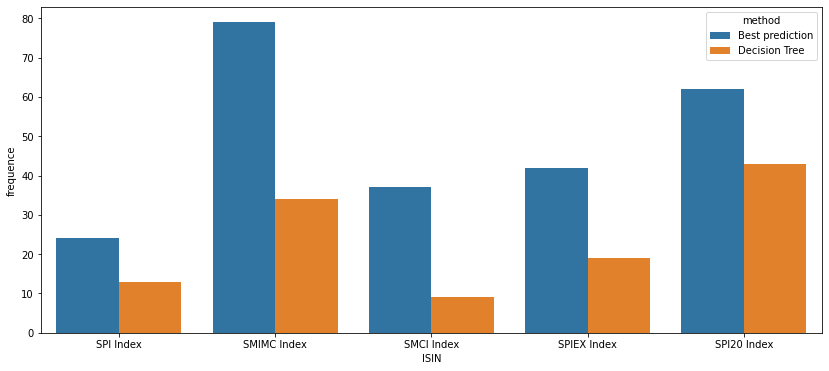

In [164]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_bet.sum(axis=0), df_pred_dt.sum(axis=0)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

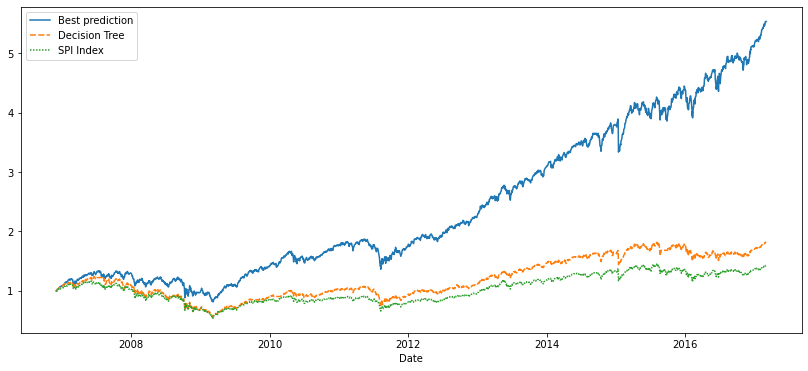

In [166]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_bet[split_index:]), pred_to_perf(df_pred_dt)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

### Random Forest

In [167]:
# Number of trees in Random Forest
rf_n_estimators = list(range(100,250,10))

# Maximum number of levels in tree
rf_max_depth = list(range(10,20))
rf_max_depth.append(None)

# Minimum number of samples required to be at a leaf node
rf_min_samples_leaf = list(range(1,5))

# Minimum number of samples required to split a node
rf_min_samples_split = list(range(1,5))

rf_grid = {'n_estimators'     : rf_n_estimators,
           'max_depth'        : rf_max_depth, 
           'min_samples_leaf' : rf_min_samples_leaf, 
           'min_samples_split': rf_min_samples_split }

In [168]:
rf_default = RandomForestClassifier()

rf_random_cv = RandomizedSearchCV(estimator = rf_default, param_distributions = rf_grid, 
                               n_iter = 100, cv = n_split, verbose = 1, 
                               n_jobs = -1)
rf_random_cv.fit(X_train,y_train)

print(rf_random_cv.best_params_)
best_param_rf = list(rf_random_cv.best_params_.values())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.9s finished


{'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11}


In [169]:
best_estimators, best_samples_split, best_samples_leaf, best_max_depth,  = best_param_rf

# rfc = RandomForestClassifier(criterion='gini', max_features = None, max_depth = best_max_depth,
#                             n_estimators= best_estimators, min_samples_leaf = best_samples_leaf,
#                             min_samples_split = best_samples_split)
rfc = RandomForestClassifier(criterion='gini', max_features = None, max_depth = None,
                             n_estimators= 1000)


rfc = rfc.fit(X_train, y_train)
y_hat_rfc_train = rfc.predict(X_train)
y_hat_rfc_test = rfc.predict(X_test)
df_pred_rfc = pd.DataFrame(data=y_hat_rfc_test, columns=indices_price.columns, index=best_bet[split_index:].index)

In [170]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_rfc_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_rfc_test, y_test), 2), '%')

Accuracy on train set 100.0 %
Accuracy on test set 6.56 %


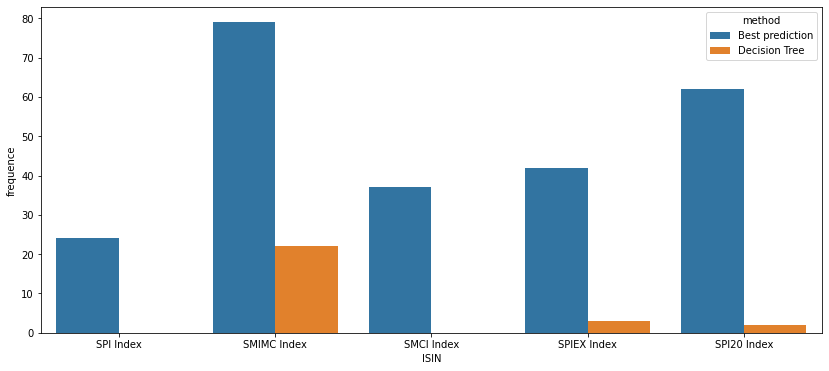

In [171]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_bet.sum(axis=0), df_pred_rfc.sum(axis=0)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

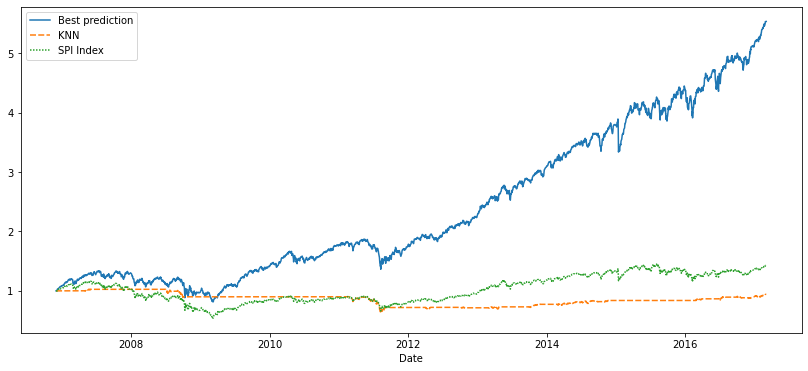

In [172]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_bet[split_index:]), pred_to_perf(df_pred_rfc)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

# Neural Network

In [624]:
import torch
from torch import nn
from torch.nn import functional as F
from itertools import combinations

## DATA

In [1016]:
input_period = 90

In [1017]:
best_bet = indices_price.pct_change(periods=30).rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 0., 5: 1.}).shift(-30).iloc[input_period:].dropna()
best_bet = best_bet.asfreq(freq='M', method='ffill')

In [1018]:
# taking account of t=0 data
x = []
cc = [p for p in itertools.permutations(daily_returns.columns, 2)]
df_price = indices_price
df_ret = df_price.pct_change().fillna(0)
df_ret_cum = (1 + df_ret).cumprod()
df_ret_diff = pd.concat([df_ret[c[1]].sub(df_ret[c[0]]) for c in cc], axis=1, keys=cc)
df_ret_diff_cum = (1 + df_ret_diff).cumprod()
df_ema_10 = df_ret_diff_cum.ewm(span=10).mean()
df_ema_130 = df_ret_diff_cum.ewm(span=130).mean()
df_input = df_ema_130 - df_ema_10
for i in best_bet.index:
    df_input = df_input.loc[:i]
    df_input = df_input.iloc[-input_period:]
    x.append(df_input.values)

In [1019]:
# reseting data at t=0 at each sample
x = []
cc = [p for p in itertools.permutations(daily_returns.columns, 2)]
for i in best_bet.index:
    df_price = indices_price.loc[:i]
    df_ret = df_price.iloc[-input_period:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    df_ret_diff = pd.concat([df_ret[c[1]].sub(df_ret[c[0]]) for c in cc], axis=1, keys=cc)
    df_ret_diff_cum = (1 + df_ret_diff).cumprod()
    df_ema_10 = df_ret_diff_cum.ewm(span=10).mean()
    df_ema_130 = df_ret_diff_cum.ewm(span=130).mean()
    x_temp = df_ema_130 - df_ema_10
    x.append(x_temp.values)

In [1020]:
X = np.array(x)
y = np.array(best_bet)

In [1021]:
np.shape(X)

(248, 90, 20)

In [1022]:
np.shape(y)

(248, 5)

In [1023]:
# split_index = len(y) // 2
split_index = 200
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[:split_index:]
X_test = X_test[4:]
y_test = y_test[4:]

In [1024]:
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

train_mean = X_train.mean(dim=[1], keepdim=True)
train_std = X_train.std(dim=[1], keepdim=True)
X_train = X_train.sub_(train_mean).div_(train_std)

test_mean = X_test.mean(dim=[1], keepdim=True)
test_std = X_test.std(dim=[1], keepdim=True)
X_test = X_test.sub_(test_mean).div_(test_std)

train_size = X_train.size(0)
shuffle_idx = torch.randperm(train_size)
X_train = X_train[shuffle_idx, :, :]
y_train = y_train[shuffle_idx, :]

## Models

In [1030]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(1800, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

In [1044]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(30, 4))
        # 32 x (90 - 29) x (20 - 3) = 16 x 61 x 17 => 16 x 30 x 8
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(7, 2))
        # 64 x (30 - 6) x (8 - 1) = 32 x 24 x 7 => 32 * 12 * 3
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(1152, 64)
        self.fc2 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.1)
        self.drop2d = nn.Dropout2d(0.1)

    def forward(self, x):
        
        x = x.view(-1, 1, x.size(1), x.size(2))
    
        x = self.relu(self.pool(self.drop2d(self.conv1(x))))

        # x = self.relu(self.conv2(x))
        x = self.relu(self.pool(self.drop2d(self.conv2(x))))
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [1035]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5))
        # 32 x (180 - 4) x (20 - 4) = 16 x 176 x 16 => 16 x 88 x 8
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        # 64 x (88 - 2) x (8 - 2) = 32 x 86 x 6 => 32 * 43 * 3
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(4128, 64)
        self.fc2 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.5)
        self.drop2d = nn.Dropout2d(0.3)

    def forward(self, x):
        
        x = x.view(-1, 1, x.size(1), x.size(2))
    
        x = self.relu(self.pool(self.drop2d(self.conv1(x))))

        # x = self.relu(self.conv2(x))
        x = self.relu(self.pool(self.drop2d(self.conv2(x))))

        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [1036]:
def output_to_acc(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [1049]:
(X_train.size(0), X_train.size(1), X_train.size(2))

(200, 90, 20)

In [1060]:
batch_size = 10
hidden_size = 5
num_layers = 2
input_size = X_train.size(2)

rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=.1)

h0 = torch.randn(num_layers, batch_size, hidden_size)
c0 = torch.randn(num_layers, batch_size, hidden_size)

In [1064]:
b = 1
mini_batch_size = 10
input = X_train.narrow(0, b, mini_batch_size)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape

torch.Size([10, 90, 5])

In [1056]:
X_train.narrow(0, 4, mini_batch_size).shape

torch.Size([10, 90, 20])

In [1045]:
model = ConvNet()

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

eta = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
mini_batch_size = 10
nb_epochs = 20

train_acc_list = []
test_acc_list = []
for e in range(nb_epochs):
    
    acc_loss = 0
    model.train()
    
    for b in range(0, X_train.size(0), mini_batch_size):
        optimizer.zero_grad()
        
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        loss.backward()
        
        optimizer.step()
    
    model.eval()
    train_acc = output_to_acc(model, X_train, y_train)
    train_acc_list.append(train_acc)
    test_acc = output_to_acc(model, X_test, y_test)
    test_acc_list.append(test_acc)
    if e % 2 == 0:
        print('epoch', e + 1, ':', acc_loss)

epoch 1 : 10.797224253416061
epoch 3 : 9.555687099695206
epoch 5 : 9.343577682971954
epoch 7 : 8.561355412006378
epoch 9 : 8.154195189476013
epoch 11 : 7.336174160242081
epoch 13 : 6.291528135538101
epoch 15 : 5.312699198722839
epoch 17 : 4.682442858815193
epoch 19 : 3.607103005051613


In [1075]:
output[0]

tensor([[-5.0191e-02, -7.3324e-02,  1.6250e-01, -1.2053e-01,  4.5822e-01],
        [-7.8597e-02, -1.6890e-02,  6.9983e-02, -9.5303e-02,  2.6084e-01],
        [-5.4833e-02, -2.3689e-02,  2.9018e-02, -7.5995e-02,  1.0449e-01],
        [-4.7324e-02, -4.7717e-02,  8.6851e-03, -7.1064e-02,  3.7744e-02],
        [-3.8415e-02, -7.0872e-02, -3.8067e-03, -7.6203e-02,  1.3612e-02],
        [-3.6690e-02, -8.4077e-02, -1.0296e-02, -7.8423e-02,  7.5337e-03],
        [-3.6696e-02, -9.0407e-02, -1.0145e-02, -7.9149e-02,  1.5146e-02],
        [-3.4981e-02, -9.4842e-02, -1.2041e-02, -8.1165e-02,  1.3800e-02],
        [-5.7403e-02, -6.4227e-02, -3.9267e-02, -7.6727e-02,  2.1333e-02],
        [-5.6336e-02, -1.0185e-01, -2.3081e-02, -7.4348e-02, -4.7362e-03],
        [-4.1337e-02, -9.6797e-02, -2.1818e-02, -7.8565e-02,  6.4705e-03],
        [-6.3882e-02, -1.0688e-01, -1.3271e-02, -6.7071e-02, -1.4688e-02],
        [-7.0672e-02, -1.1273e-01, -8.0281e-03, -6.5278e-02, -2.7800e-02],
        [-6.2463e-02, -1.

In [1074]:
output.shape

torch.Size([10, 90, 5])

In [1071]:
mini_batch_size = 10
hidden_size = 5
num_layers = 5
input_size = X_train.size(2)
dropout = .2

rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

criterion = nn.BCELoss()

eta = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

nb_epochs = 10

train_acc_list = []
test_acc_list = []

for e in range(nb_epochs):
    
    acc_loss = 0
    model.train()
    
    for b in range(0, X_train.size(0), mini_batch_size):
        optimizer.zero_grad()
        
        h0 = torch.randn(num_layers, mini_batch_size, hidden_size)
        c0 = torch.randn(num_layers, mini_batch_size, hidden_size)
        
        input = X_train.narrow(0, b, mini_batch_size)
        
        output, _ = rnn(input, (h0, c0))
        
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        loss.backward()
        
        optimizer.step()
    
    model.eval()
    train_acc = output_to_acc(model, X_train, y_train)
    train_acc_list.append(train_acc)
    test_acc = output_to_acc(model, X_test, y_test)
    test_acc_list.append(test_acc)
    if e % 2 == 0:
        print('epoch', e + 1, ':', acc_loss)

ValueError: Using a target size (torch.Size([10, 5])) that is different to the input size (torch.Size([10, 90, 5])) is deprecated. Please ensure they have the same size.

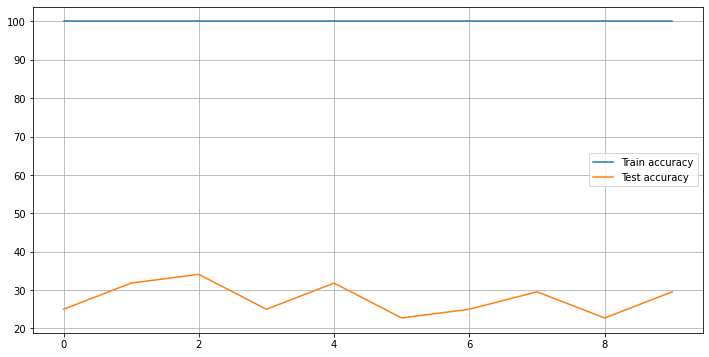

In [1070]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_acc_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_acc_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

In [965]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [966]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 30.00%


In [863]:
df_pred_convnet = pd.DataFrame(data=prediction_test, columns=indices_price.columns, index=best_bet[204:].index)


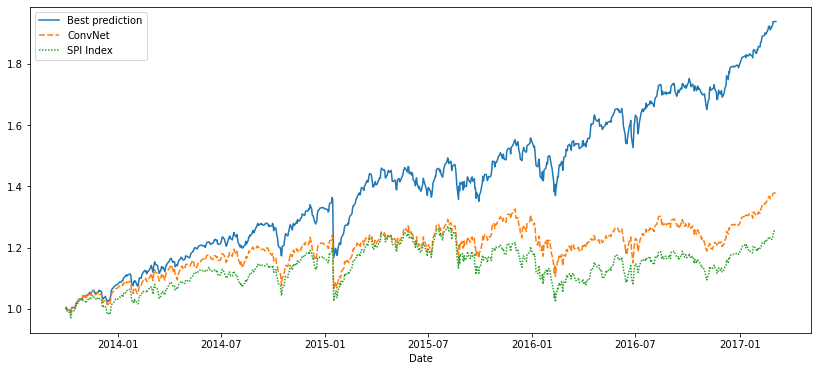

In [967]:
fig = plt.figure(figsize=(14,6))
split_date = str(best_bet.iloc[204].name)
df_results_plot = pd.concat([pred_to_perf(best_bet[204:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

In [535]:
model = MLP()

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

eta = 5e-1
mini_batch_size = 5
nb_epochs = 20

for e in range(nb_epochs):
    acc_loss = 0

    for b in range(0, X_train.size(0), mini_batch_size):
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        # print(output)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for p in model.parameters():
                p -= eta * p.grad

    print('epoch', e + 1, ':', acc_loss)

epoch 1 : 16.554613947868347
epoch 2 : 14.862844556570053
epoch 3 : 14.55127876996994
epoch 4 : 14.298196792602539
epoch 5 : 14.190958470106125
epoch 6 : 13.97439643740654
epoch 7 : 13.738138943910599
epoch 8 : 13.736871615052223
epoch 9 : 13.610996589064598
epoch 10 : 13.259048476815224
epoch 11 : 13.33023227751255
epoch 12 : 13.458964869379997
epoch 13 : 12.949641302227974
epoch 14 : 12.57250814139843
epoch 15 : 13.025222438387573
epoch 16 : 12.62768642604351
epoch 17 : 13.049843000248075
epoch 18 : 13.045604780316353
epoch 19 : 13.58894558250904
epoch 20 : 12.445861880667508
